Here I will forecast the annual totals for the next 20 years of global flight passengers.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


I aggregated a dataset ranging from 1970-2022 for the annual totals of global flight passengers, global population, global *{real} {GDP}*, and global covid-19 fatalities.

There are many different ways that this could be forecasted. The most straightforward way would be to look only at flight passengers as a function of time, fit a model, and extend out 20 years.

I chose to go a layer beneath that by looking at 3 variables which have explanatory effects on flight passenger totals - population, gdp, and covid-19 fatalities, then:

1) Fitting a model of passenger totals as a function of these independent variables

2) Forecasting the next 20 years of these independent variables

3) Using the coefficients from 1) with the forecasted values from 2) to generate predictions for passenger totals over the next 20 years.

First, I will read in the data from the CSV I have aggregated it in.

With a dataset this small, it would not normally be necessary to use SQL/Database, but in this case I will write the data to two SQLite database tables, then pull it right back out into a pandas df with a SQL query, joining on year. 

In [2]:
df = pd.read_csv('data.csv')
df1 = df[['year', 'passengers', 'population', 'gdp']]
df2 = df[['year', 'covid_fatalities']]

conn = sqlite3.connect('database.db')
df1.to_sql('pass_pop', conn, if_exists='replace', index=False)
df2.to_sql('covid', conn, if_exists='replace', index=False)

query = '''
SELECT pass_pop.year, pass_pop.passengers, pass_pop.population, pass_pop.gdp, covid.covid_fatalities
FROM pass_pop
INNER JOIN covid
ON pass_pop.year = covid.year
'''
new_df = pd.read_sql_query(query, conn)
conn.close()
print(new_df.head())

   year  passengers  population        gdp  covid_fatalities
0  1970        0.31         3.7  23.866740               0.0
1  1971        0.33         3.8  24.855937               0.0
2  1972        0.38         3.9  26.038226               0.0
3  1973        0.40         3.9  27.766318               0.0
4  1974        0.42         4.0  28.412737               0.0


In [3]:
#putting the df columns into lists out of personal preference

years = new_df['year'].tolist()
passenger_counts = new_df['passengers'].tolist()
population_counts = new_df['population'].tolist()
gdps = new_df['gdp'].tolist()
covid_fatalities = new_df['covid_fatalities'].tolist()

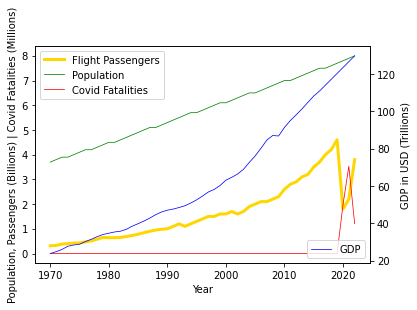

In [4]:
#preliminary chart of unprocessed data

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(years, passenger_counts, color='gold', linewidth=3, label='Flight Passengers')
ax1.plot(years, population_counts, color='green', linewidth=.75, label='Population')
ax1.plot(years, covid_fatalities, color='red', linewidth=.75, label='Covid Fatalities')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population, Passengers (Billions) | Covid Fatalities (Millions)')
ax2.set_ylabel('GDP in USD (Trillions)')
ax2.plot(years, gdps, color='blue', linewidth=.75, label='GDP')
ax1.legend()
plt.legend(loc='lower right')
plt.show()

1) I will fit a model for the three independent variables (population, gdp, and covid fatalities) to the dependent variable (flight passengers) using linear regression

In [5]:
X = np.column_stack((population_counts, gdps, covid_fatalities))
y = np.array(passenger_counts)

# Normalizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fitting a linear regression model to the data
model = LinearRegression().fit(X, y)

# Predicting the dependent variable using the model
y_pred = model.predict(X)

# Print the model coefficients and R^2 score
print("Coefficients: ", ["{:.5f}".format(x) for x in model.coef_])
print("R^2 score: ", model.score(X, y))

Coefficients:  ['-0.30701', '0.05097', '-0.70770']
R^2 score:  0.9638604058289866


Here is the model:

$passengerBil = -.31popBil + .051gdpTril -.71covidMil$




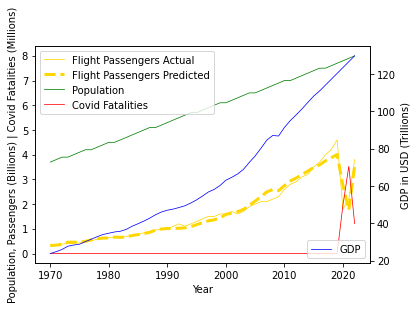

In [6]:
#same chart as before but adding in the model predicted values for flight passengers in contrast to the actuals

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(years, passenger_counts, color='gold', linewidth=.75, label='Flight Passengers Actual')
ax1.plot(years, y_pred, color='gold', linewidth=3, label='Flight Passengers Predicted', linestyle='dashed')
ax1.plot(years, population_counts, color='green', linewidth=.75, label='Population')
ax1.plot(years, covid_fatalities, color='red', linewidth=.75, label='Covid Fatalities')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population, Passengers (Billions) | Covid Fatalities (Millions)')
ax2.set_ylabel('GDP in USD (Trillions)')
ax2.plot(years, gdps, color='blue', linewidth=.75, label='GDP')
ax1.legend()
plt.legend(loc='lower right')
plt.show()

2) Next, I will forecast each of the three independent variables for the next 20 years.

I will use a linear regression model for population and gdp, using log values for gdp.

For the next 20 years of covid fatalities, I don't believe the right approach is to attempt to model itself with time, since covid-19 is only a recent phenomenon with 3 years of data. Instead, I will make the assumption that covid-19 fatalities diminish to $0$ over the next five years and remain at $0$ thereafter.

In [7]:
# Fitting a linear regression model to population
X = np.array(years).reshape(-1, 1)
y = np.array(population_counts)
model_pop = LinearRegression().fit(X, y)

# Make predictions/forecast for the next 20 years of the population
X_future = np.array(list(range(2023, 2043))).reshape(-1, 1)
y_pred_pop = model_pop.predict(X_future)


# Fitting an exponential trend model to gdp
X = np.array(years).reshape(-1, 1)
y = np.log(np.array(gdps))
model_gdp = LinearRegression().fit(X, y)

# Make predictions/forecast for the next 20 years of gdp
X_future = np.array(list(range(2023, 2043))).reshape(-1, 1)
y_pred_gdp = np.exp(model_gdp.predict(X_future))
             

future_years = list(range(2023, 2043))

yearcount = 5
latest_fatalities = covid_fatalities[-1]
est_fatalities = [latest_fatalities * (0.5 ** i) for i in range(yearcount)]
for _ in range(20-yearcount):
    est_fatalities.append(0)
    

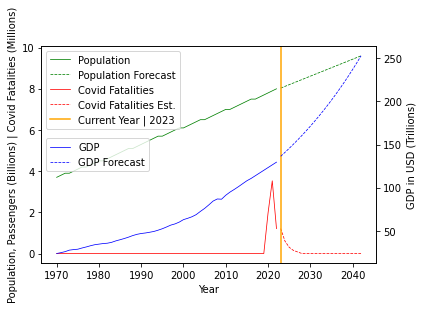

In [8]:
#chart showing the historical, then forecasted values of the three independent variables through 2042
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(years, population_counts, color='green', linewidth=.75, label='Population')
ax1.plot(future_years, y_pred_pop, color='green', linewidth=.75, label='Population Forecast', linestyle='dashed')
ax1.plot(years, covid_fatalities, color='red', linewidth=.75, label='Covid Fatalities')
ax1.plot(future_years, est_fatalities, color='red', linewidth=.75, label='Covid Fatalities Est.', linestyle='dashed')
ax1.axvline(x=2023, color='orange', label='Current Year | 2023')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population, Passengers (Billions) | Covid Fatalities (Millions)')
ax2.set_ylabel('GDP in USD (Trillions)')
ax2.plot(years, gdps, color='blue', linewidth=.75, label='GDP')
ax2.plot(future_years, y_pred_gdp, color='blue', linewidth=.75, label='GDP Forecast', linestyle='dashed')
ax1.legend()
plt.legend(loc='center left')
plt.show()

3) Finally, I will put the pieces together. I will take the model from part 1) and apply that to the forecasted values of the independent variables in part 2) to generate a forecast for global flight passengers through 2042

In [9]:
new_X = np.column_stack((y_pred_pop, y_pred_gdp, est_fatalities))
new_y_pred = model.predict(new_X)
print("Predicted Flight Passengers", new_y_pred)

Predicted Flight Passengers [ 3.87198659  4.50419849  4.92989604  5.2563678   5.53739102  5.82675143
  6.0712044   6.32455352  6.58709215  6.85912336  7.14096018  7.43292598
  7.73535481  8.0485917   8.37299309  8.70892716  9.05677422  9.41692716
  9.78979179 10.17578731]


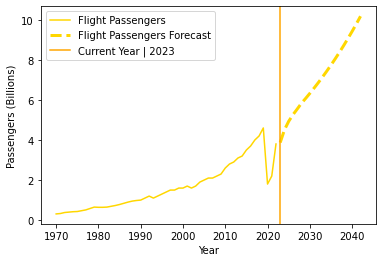

In [10]:
fig, ax1 = plt.subplots()
plt.plot(years, passenger_counts, color='gold', linewidth=1.5, label='Flight Passengers')
plt.plot(future_years, new_y_pred, color='gold', linewidth=3, label='Flight Passengers Forecast', linestyle='dashed')
plt.axvline(x=2023, color='orange', label='Current Year | 2023')
plt.xlabel('Year')
plt.ylabel('Passengers (Billions)')
plt.legend(loc='upper left')
plt.show()